In [1]:
import yaml

from snowflake.snowpark import *
import snowflake.snowpark.functions as snowFunc
import snowflake.snowpark.types as snowTypes

import numpy as np
import pandas as pd
import simplejson as json
import datetime

from tqdm import tqdm

import scipy.stats as stats

from sklearn.cluster import KMeans
import statsmodels.api as sm
from scipy.stats import linregress


# Add parent directory to path
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


CONFIG_PATH = '/Users/sunaybhat/Documents/GitHub/DS_config.yaml'
with open(CONFIG_PATH, 'r') as yamlfile: config = yaml.load(yamlfile, Loader=yaml.FullLoader)

session = Session.builder.configs({
                    "account": config['SNOWFLAKE']['account'],
                    "user": config['SNOWFLAKE']['user'],
                    "password": config['SNOWFLAKE']['password'],
                    "role": config['SNOWFLAKE']['ROLES']['user'],
                    "warehouse": config['SNOWFLAKE']['WAREHOUSES']['med'],
                    "database": config['SNOWFLAKE']['DATABASES']['sandbox'],
                    "schema": config['SNOWFLAKE']['SCHEMAS']['sunay'],
                }).create()

In [3]:
df = session.sql('''
WITH overall_percentiles AS (
    SELECT
        AVG(max_posterior_probability) as max_posterior_probability,
        AVG(max_prior_probability) as max_prior_probability,
        AVG(prior_entropy) as prior_entropy,
        AVG(posterior_entropy) as posterior_entropy,
        AVG(max_posterior_probability - max_prior_probability) AS probability_change,
        AVG(prior_entropy - posterior_entropy) as entropy_reduction
    FROM 
        DATASCIENCE.ANALYSIS.DEMO_ENRICHMENT_SUMMARY
),

-- Percentile analysis by category
category_percentiles AS (
    SELECT
        CATEGORY,
        AVG(max_posterior_probability) as max_posterior_probability,
        AVG(max_prior_probability) as max_prior_probability,
        AVG(prior_entropy) as prior_entropy,
        AVG(posterior_entropy) as posterior_entropy,
        AVG(max_posterior_probability - max_prior_probability) AS probability_change,
        AVG(prior_entropy - posterior_entropy) as entropy_reduction,
    FROM 
        DATASCIENCE.ANALYSIS.DEMO_ENRICHMENT_SUMMARY
    GROUP BY 
        CATEGORY
)

-- Combine the results
SELECT 
    'OVERALL' AS category,
    max_posterior_probability,
    max_prior_probability,
    prior_entropy,
    posterior_entropy,
    probability_change,
    entropy_reduction
FROM 
    overall_percentiles

UNION ALL

SELECT 
    CATEGORY,
    max_posterior_probability,
    max_prior_probability,
    prior_entropy,
    posterior_entropy,
    probability_change,
    entropy_reduction
FROM 
    category_percentiles
ORDER BY 
    CASE WHEN category = 'OVERALL' THEN 0 ELSE 1 END,
    probability_change DESC;
'''
).to_pandas()

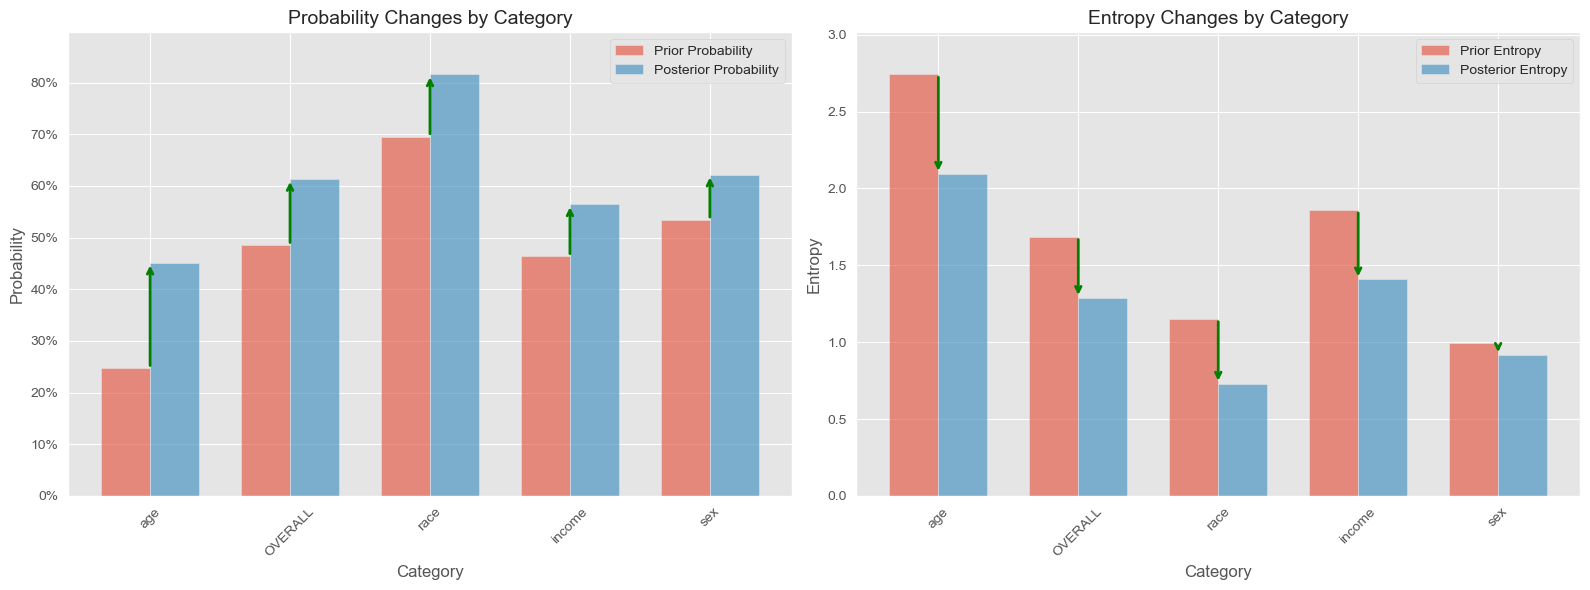

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as patches

# Set the style for the plot
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Filter out the 'OVERALL' category and sort
df_categories = df.sort_values('PROBABILITY_CHANGE', ascending=False)

# Plot 1: Probability changes with arrows
categories = df_categories['CATEGORY']
prior_probs = df_categories['MAX_PRIOR_PROBABILITY']
posterior_probs = df_categories['MAX_POSTERIOR_PROBABILITY']

# Create the bar chart for prior and posterior probabilities side by side
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars_prior = ax1.bar(x - width/2, prior_probs, width, alpha=0.6, label='Prior Probability')
bars_posterior = ax1.bar(x + width/2, posterior_probs, width, alpha=0.6, label='Posterior Probability')

# Set the x-axis ticks and labels
ax1.set_xticks(x)
ax1.set_xticklabels(categories)

# Add arrows to show the change
for i, (prior, posterior, cat) in enumerate(zip(prior_probs, posterior_probs, categories)):
    if posterior > prior:
        ax1.annotate('', 
                    xy=(i, posterior), 
                    xytext=(i, prior),
                    arrowprops=dict(arrowstyle='->', color='green', lw=2))
    else:
        ax1.annotate('', 
                    xy=(i, posterior), 
                    xytext=(i, prior),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Customize the probability plot
ax1.set_title('Probability Changes by Category', fontsize=14)
ax1.set_xlabel('Category', fontsize=12)
ax1.set_ylabel('Probability', fontsize=12)
ax1.set_ylim(0, max(posterior_probs.max(), prior_probs.max()) * 1.1)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Plot 2: Entropy changes with arrows
prior_entropy = df_categories['PRIOR_ENTROPY']
posterior_entropy = df_categories['POSTERIOR_ENTROPY']
# Create the bar chart for entropy with side-by-side bars
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars_prior_entropy = ax2.bar(x - width/2, prior_entropy, width, alpha=0.6, label='Prior Entropy')
bars_posterior_entropy = ax2.bar(x + width/2, posterior_entropy, width, alpha=0.6, label='Posterior Entropy')

# Set the x-axis ticks and labels
ax2.set_xticks(x)
ax2.set_xticklabels(categories)

# Add arrows to show the entropy change
for i, (prior, posterior, cat) in enumerate(zip(prior_entropy, posterior_entropy, categories)):
    if prior > posterior:  # Entropy reduction is good
        ax2.annotate('', 
                    xy=(i, posterior), 
                    xytext=(i, prior),
                    arrowprops=dict(arrowstyle='->', color='green', lw=2))
    else:
        ax2.annotate('', 
                    xy=(i, posterior), 
                    xytext=(i, prior),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Customize the entropy plot
ax2.set_title('Entropy Changes by Category', fontsize=14)
ax2.set_xlabel('Category', fontsize=12)
ax2.set_ylabel('Entropy', fontsize=12)
ax2.set_ylim(0, max(prior_entropy.max(), posterior_entropy.max()) * 1.1)
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# Convert y-axis to percentage format for both plots
import matplotlib.ticker as mtick

# For probability plot (ax1)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 1.0 is the base value for 100%
# ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 1.0 is the base value for 100%

# For entropy plot (ax2)
# Since entropy is not typically shown as a percentage, we'll leave it in its original format
# But if you want to convert it to percentage of maximum possible entropy:
# max_possible_entropy = np.log2(len(categories))  # Maximum possible entropy
# ax2.yaxis.set_major_formatter(mtick.PercentFormatter(max_possible_entropy, decimals=1))


plt.tight_layout()
p = plt


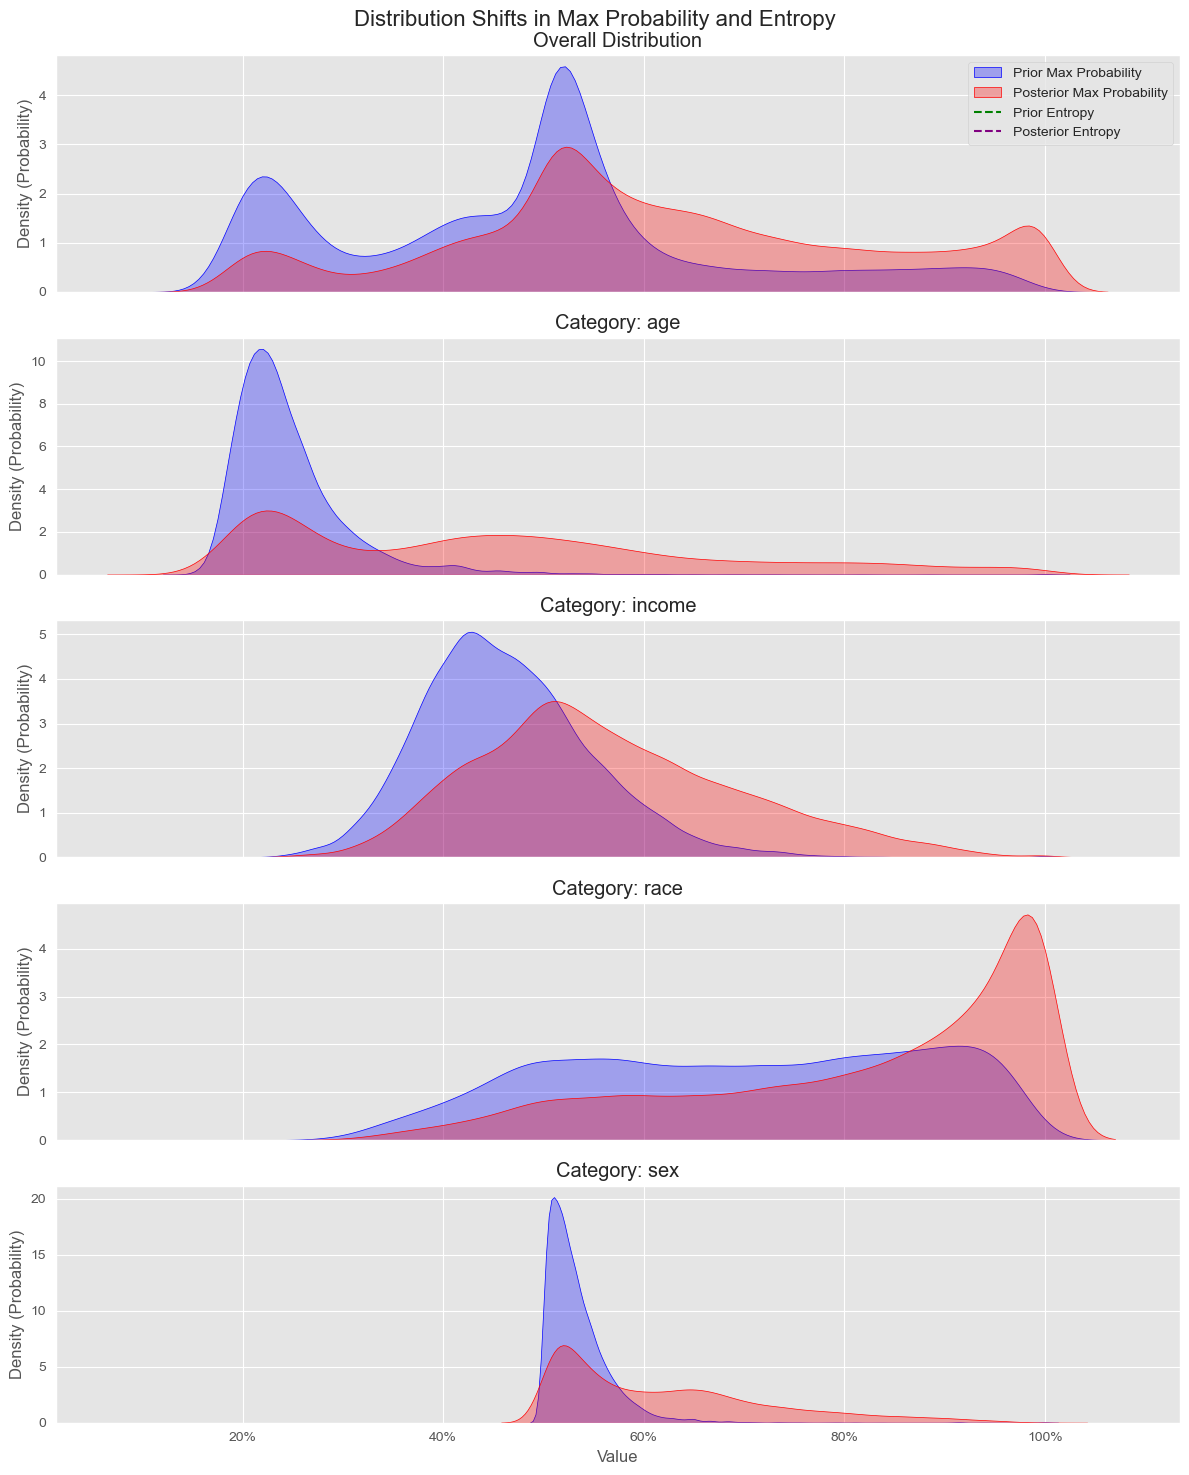

In [14]:
# Query to sample data from the DEMO_ENRICHMENT_SUMMARY table
df = session.sql('''
SELECT 
    DEVICE_HASH,
    CATEGORY,
    max_prior_probability,
    max_posterior_probability,
    prior_entropy,
    posterior_entropy
FROM 
    DATASCIENCE.ANALYSIS.DEMO_ENRICHMENT_SUMMARY
SAMPLE (100000 ROWS)
''').to_pandas()


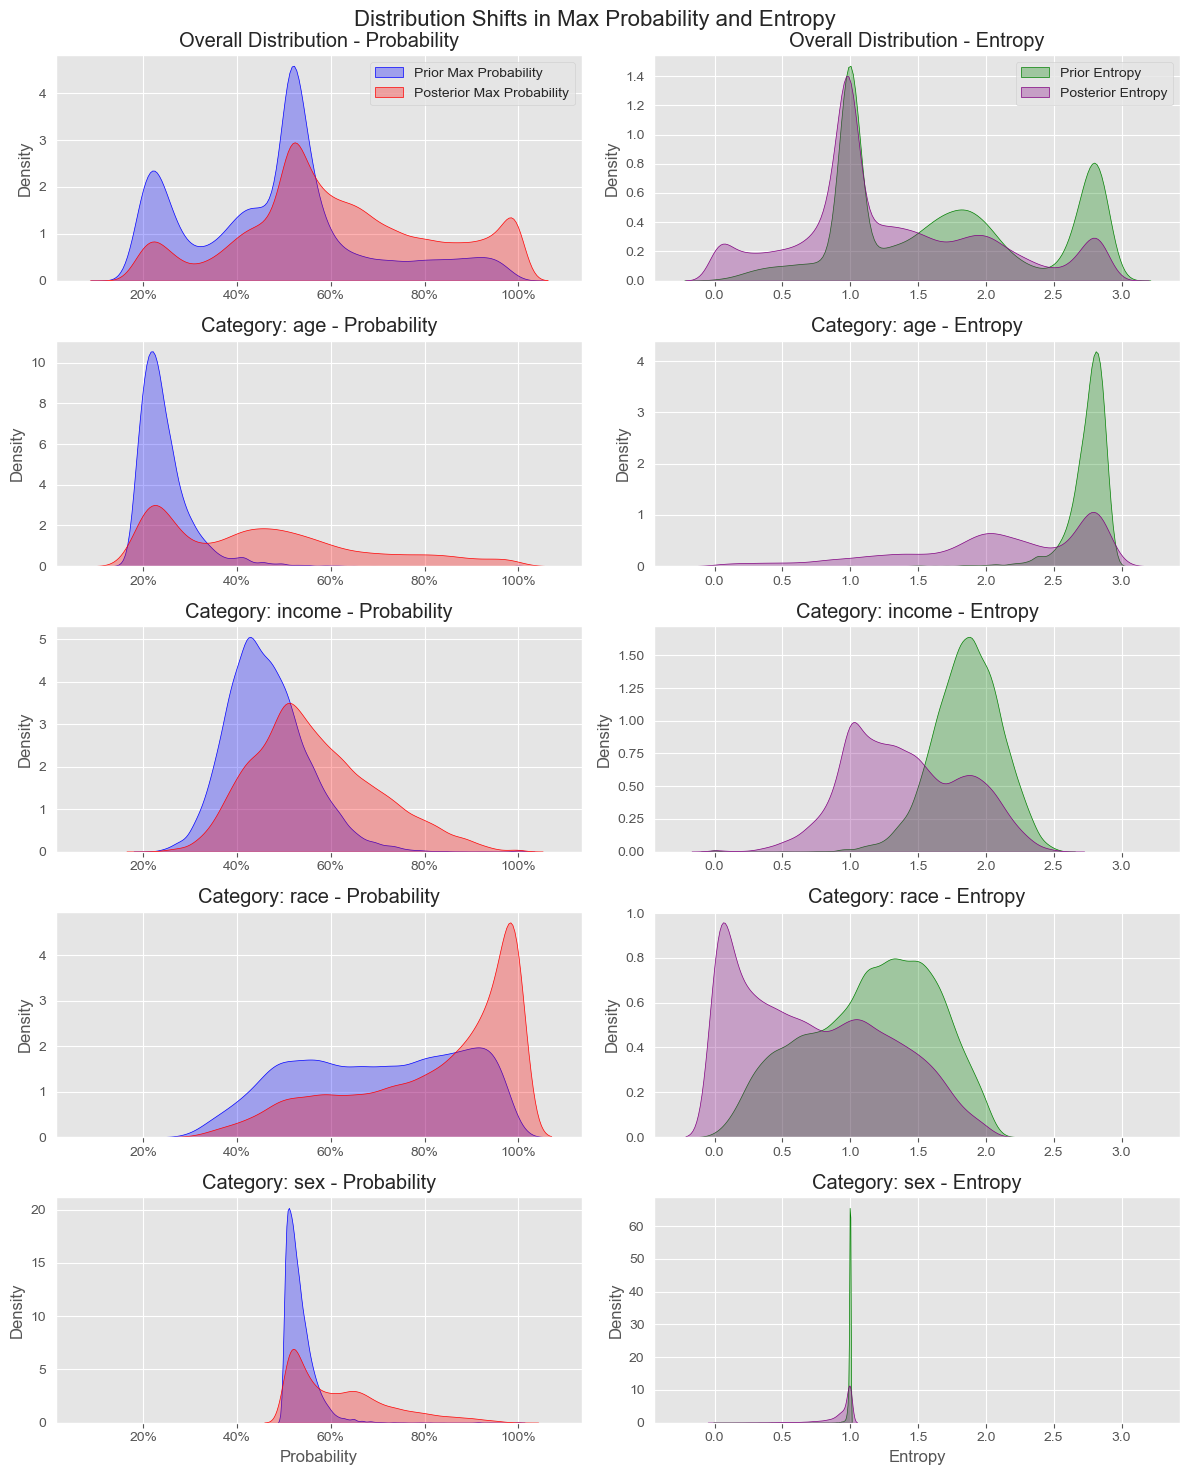

In [22]:
# Create a figure with 5 subplots (1 for overall, 4 for each category)
fig, axes = plt.subplots(5, 2, figsize=(12, 15), sharex='col')
fig.suptitle('Distribution Shifts in Max Probability and Entropy', fontsize=16)

# Categories to plot (including 'Overall')
categories = ['Overall'] + sorted(df['CATEGORY'].unique().tolist())

# Plot for each category
for i, category in enumerate(categories):
    ax_prob = axes[i, 0]  # Left column for probability
    ax_entropy = axes[i, 1]  # Right column for entropy
    
    if category == 'Overall':
        data = df  # Use all data for overall plot
        title = "Overall Distribution"
    else:
        data = df[df['CATEGORY'] == category]  # Filter by category
        title = f"Category: {category}"
    
    # Plot KDE for max probabilities
    sns.kdeplot(data['MAX_PRIOR_PROBABILITY'], ax=ax_prob, color='blue', label='Prior Max Probability', fill=True, alpha=0.3)
    sns.kdeplot(data['MAX_POSTERIOR_PROBABILITY'], ax=ax_prob, color='red', label='Posterior Max Probability', fill=True, alpha=0.3)

    # Plot KDE for entropy
    sns.kdeplot(data['PRIOR_ENTROPY'], ax=ax_entropy, color='green', label='Prior Entropy', fill=True, alpha=0.3)
    sns.kdeplot(data['POSTERIOR_ENTROPY'], ax=ax_entropy, color='purple', label='Posterior Entropy', fill=True, alpha=0.3)
    
    # Set titles and labels
    ax_prob.set_title(f"{title} - Probability")
    ax_entropy.set_title(f"{title} - Entropy")
    
    # Show x ticks on all subplots
    ax_prob.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
    ax_entropy.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
    
    # Format x-axis as percentage for probabilities
    ax_prob.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Add y-axis labels
    if i == 2:  # Middle row
        ax_prob.set_ylabel('Density')
        ax_entropy.set_ylabel('Density')
    
    # Add legends only to the first row
    if i == 0:
        ax_prob.legend(loc='upper right')
        ax_entropy.legend(loc='upper right')

# Add x-axis labels to the bottom row
axes[-1, 0].set_xlabel('Probability')
axes[-1, 1].set_xlabel('Entropy')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust to make room for the suptitle
plt.show()
